# 1 - Import Libraries

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import SGD
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imgaug import augmenters as iaa
import pickle
import pandas as pd
import cv2
import random
import ntpath
import zipfile
import re
import os
import gzip
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split 
from IPython.display import display, HTML
import keras

import json

import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


np.random.seed(0)

Using TensorFlow backend.


# 2 - Data Loading

In [96]:
# 1 - Mount Google
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# 2 - Data Extraction
data_dir = '/content/drive/My Drive/Industry-4.0/data/'
data_extract = data_dir + "train_images.zip"
zip_ref = zipfile.ZipFile(data_extract , 'r').extractall()

In [0]:
# 3 - Data Loading

data_info = pd.read_csv( data_dir + "train.csv")
data_info['Image'] = data_info['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
data_info['Label'] = data_info['ImageId_ClassId'].apply(lambda x: x.split('_')[1] )
data_info['hasMask'] = ~ data_info['EncodedPixels'].isna()
data_images = data_info['Image']
train_images = data_images[:int(0.8 * len(data_images))]
test_images = data_images[int(0.8 * len(data_images)) : ]



# [ TRAIN DATASET ]
train_info = data_info.loc[data_info['Image'].isin(train_images) ]
train_image_distribution = train_info.groupby('Image').agg(np.sum).reset_index()
train_image_distribution.sort_values('hasMask', ascending = False, inplace = True)
train_label_distribution = train_info.groupby('Label').agg(np.sum).reset_index()
train_label_distribution.sort_values('Label', ascending = False, inplace = True)


# [ TEST DATASET ]
test_info = data_info.loc[data_info['Image'].isin(test_images) ]
test_image_distribution = test_info.groupby('Image').agg(np.sum).reset_index()
test_image_distribution.sort_values('hasMask', ascending = False, inplace = True)
test_label_distribution = test_info.groupby('Label').agg(np.sum).reset_index()
test_label_distribution.sort_values('Label', ascending = False, inplace = True)




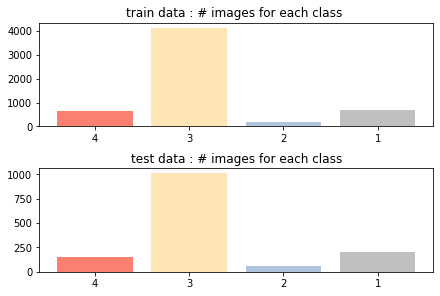

In [0]:
# 4 - Class distribution through train , test data
fig, axs = plt.subplots(2, 1, constrained_layout=True)
axs[0].bar(train_label_distribution['Label'], train_label_distribution['hasMask'], color = ['salmon', 'moccasin', 'lightsteelblue', 'silver']) # plot the raw data as bar chart
axs[0].set_title('train data : # images for each class ')
axs[1].bar(test_label_distribution['Label'], test_label_distribution['hasMask'], color = ['salmon', 'moccasin', 'lightsteelblue', 'silver']) # plot the raw data as bar chart
axs[1].set_title('test data : # images for each class')
plt.show()

# 3 - Visualization masks of train data

In [0]:
import math
def rle2mask_visualization(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

def name_and_mask(start_idx, train_info, train_path):
    col = start_idx
    img_names = [str(i).split("_")[0] for i in train_info.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError

    labels = train_info.iloc[col:col+4, 1]
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
    return img_names[0], mask


def show_mask_image(col, train_info, train_path):
    name, mask = name_and_mask(col, train_info, train_path)
    img = cv2.imread(str(train_path / name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()



5670 5670
Coverage is : 1.68%
Coverage is : 16.93%
Coverage is : 6.96%
Coverage is : 1.22%
Coverage is : 0.3%


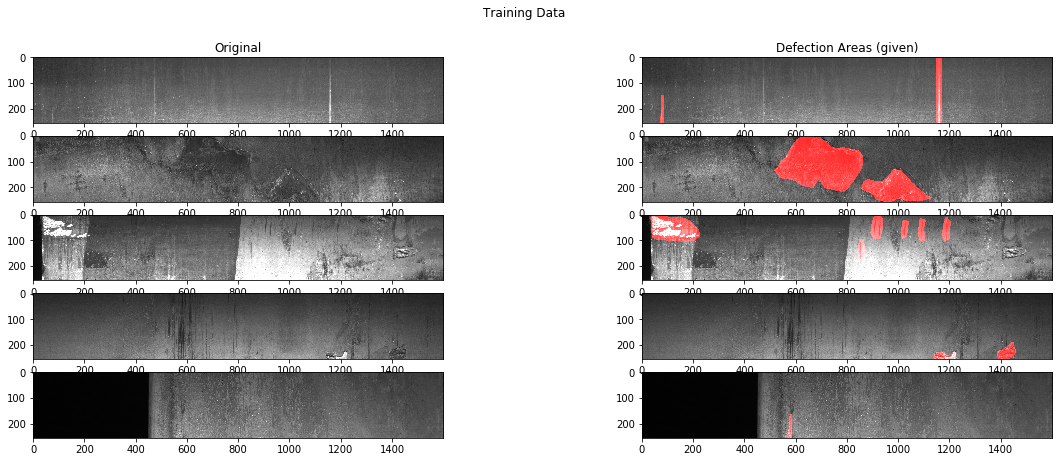

In [0]:

train_info_masked = train_info.copy()
f = lambda x: str(x)
train_info_masked['EncodedPixels'].apply(f)
train_info_masked = train_info_masked.loc[ ~train_info_masked['EncodedPixels'].isna()]
train_images_masked = list(train_info_masked['Image'])

print(len(train_info_masked), len(train_images_masked))


fig = plt.figure(figsize = (20,7))
fig.suptitle('Training Data')
columns = 2
rows = 5
for i in range(1, 11,2):
    # first image
    ax = fig.add_subplot(rows, columns, i)
    img = cv2.imread( 'train_images/' + train_images_masked[i] )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if i == 1: ax.set_title('Original')
    plt.imshow(img)
    
    # second image
    ax = fig.add_subplot(rows, columns, i + 1)
    mask = rle2mask_visualization( train_info_masked['EncodedPixels'].iloc[i], img.shape )
    img[mask == 1,0] = 255
    if i == 1: ax.set_title('Defection Areas (given)')
    plt.imshow(img)

    area_defected = len(img[mask == 1,0])
    area_total = 256*1600
    coverage = area_defected/ area_total * 100

    print("Coverage is : " + str(np.round(coverage,2)) + "%")

    
    
    
plt.show()


# 4 - Useful Methods

In [0]:

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    print(y_true_f)
    print(y_pred_f)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)



In [0]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape = (256,1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T



def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

# 5 - Data Generation

In [0]:
from numpy import  newaxis
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path = 'train_images/',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['Image'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            # Store samples
            X[i,] = img
        return X
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['Image'].iloc[ID]
            image_df = self.target_df[self.target_df['Image'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [0]:
BATCH_SIZE = 16
train_idx, val_idx = train_test_split( train_image_distribution.index, random_state = 2019, test_size = 0.15 )

train_generator = DataGenerator(
    train_idx, 
    df = train_image_distribution,
    target_df = train_info,
    batch_size = BATCH_SIZE, 
    n_classes = 4
)

val_generator = DataGenerator(
    val_idx, 
    df = train_image_distribution,
    target_df = train_info,
    batch_size = BATCH_SIZE, 
    n_classes = 4
)

# 6 - Model Building

In [0]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs = [inputs], outputs = [outputs])
    model.compile(optimizer = 'adam', loss = bce_dice_loss, metrics = [dice_coef] )
    
    return model

In [0]:
model = build_model((256, 1600, 1))
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Tensor("metrics/dice_coef/Reshape:0", shape=(?,), dtype=float32)
Tensor("metrics/dice_coef/Reshape_1:0", shape=(?,), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________

# 7 - Model Training

In [0]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_dice_coef', 
    verbose = 0, 
    save_best_only = True, 
    save_weights_only = False,
    mode = 'auto'
)

history = model.fit_generator(
    train_generator,
    validation_data = val_generator,
    callbacks = [checkpoint],
    use_multiprocessing = False,
    workers = 1,
    epochs = 10
)




Epoch 1/10





  6/534 [..............................] - ETA: 21:00 - loss: 1.6886 - dice_coef: 0.0127

KeyboardInterrupt: ignored

# 8 - Test Generator

In [0]:
test_imgs = pd.DataFrame(test_info['Image'].unique(), columns=['Image'] )

model.load_weights('model_10epochs.h5')
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list( range(i, min(test_imgs.shape[0], i + 500)))
    
    test_generator = DataGenerator(
        batch_idx,
        df = test_imgs,
        shuffle = False,
        mode = 'predict',
        base_path = 'train_images',
        target_df = test_info,
        batch_size = 1,
        n_classes = 4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers = 1,
        verbose = 1,
        use_multiprocessing = False
    )

    for j, b in tqdm(enumerate(batch_idx)):
          filename = test_imgs['Image'].iloc[b]
          image_df = test_info[test_info['Image'] == filename].copy()
          
          pred_masks = batch_pred_masks[j, ].round().astype(int)
          pred_rles = build_rles(pred_masks)

          pred_rlers = [np.nan if i == '' else i for i in pred_rles]
          
          image_df['PredictedEncodedPixels'] = pred_rles
          test_df.append(image_df)



500/500 [==============================] - 5s 11ms/step


500it [00:11, 44.25it/s]

  6/500 [..............................] - ETA: 5s

500/500 [==============================] - 5s 10ms/step


500it [00:11, 43.13it/s]

  7/500 [..............................] - ETA: 5s

500/500 [==============================] - 5s 10ms/step


500it [00:11, 45.33it/s]

  7/500 [..............................] - ETA: 5s

500/500 [==============================] - 5s 10ms/step


500it [00:11, 45.02it/s]

  6/500 [..............................] - ETA: 5s

500/500 [==============================] - 5s 10ms/step


500it [00:11, 44.23it/s]

 6/14 [===========>..................] - ETA: 0s

14/14 [==============================] - 0s 11ms/step


14it [00:00, 46.35it/s]


# 9 - Data Analytics

In [0]:
# configuration
def remove_outliers(row):
  if row['PredictedEncodedPixels'] == '1 1' : return ''
  else : return row['PredictedEncodedPixels']

data_analysis = pd.concat(test_df)
data_analysis = data_analysis[['Image', 'Label', 'EncodedPixels', 'PredictedEncodedPixels']]
data_analysis['PredictedEncodedPixels'] = data_analysis.apply(lambda row : remove_outliers(row), axis = 1)
display(data_analysis.head(5))

# 1 -  Prediction per image per defect class
def find_class (row, predictive = False):
  if predictive and row['PredictedEncodedPixels'] != '' :  return row['Label']
  elif not(predictive) and isinstance(row['EncodedPixels'] , str) :  return row['Label']
  else : return 0

data_analysis = data_analysis.copy()
data_analysis['RealClass'] = data_analysis.apply (lambda row: find_class(row), axis = 1)
data_analysis['PredictiveClass'] = data_analysis.apply (lambda row: find_class(row, True), axis = 1)
display(data_analysis.head(5))

# 2 - Prediction of defects per image
#tmp =  PREDICTIONS_perImage_perClass.groupby('Image').agg({'PredictedLabel' : 'sum' })
#tmp.columns = ['ImagePrediction']
#tmp['Image'] = tmp.index
#tmp['index'] = list(range(0, len(tmp)))
#tmp.set_index('index', inplace=True)
#PREDICTIONS_perImage = PREDICTIONS_perImage_perClass.merge(tmp, on = ['Image'])
#display(PREDICTIONS_perImage.head(5))


# 3 - Defections per image

def is_defected(row):
  if row['PredictedEncodedPixels'] != '' : return True
  else : return False

def number_of_defections(row):
  if row['ImageDefections'] != 0.0 : return True
  else : return False


#DEFECTION_perImage = data_analysis.copy()
#DEFECTION_perImage['ImageDefections'] = data_analysis.apply(lambda row: is_defected(row), axis = 1)
#DEFECTION_perImage = DEFECTION_perImage.groupby('Image').agg({'ImageDefections' : 'sum' })
#DEFECTION_perImage['ImageDefected'] = DEFECTION_perImage.apply(lambda row : number_of_defections(row), axis = 1)

# 4 - TODO
#a = DEFECTION_perImage[DEFECTION_perImage['ImageDefections'] == 1.0]
#b = DEFECTION_perImage[DEFECTION_perImage['ImageDefections'] == 2.0]
#c = DEFECTION_perImage[DEFECTION_perImage['ImageDefections'] == 3.0]
#d = DEFECTION_perImage[DEFECTION_perImage['ImageDefections'] == 4.0]

#display(DEFECTION_perImage.head(10))



,Image,Label,EncodedPixels,PredictedEncodedPixels
40216,cc0ef2b5b.jpg,1,NaN,
40217,cc0ef2b5b.jpg,2,NaN,
40218,cc0ef2b5b.jpg,3,NaN,41946 1 41948 1 41950 1 41952 1 41954 1 41956 ...
40219,cc0ef2b5b.jpg,4,NaN,
40220,cc12d964f.jpg,1,NaN,


,Image,Label,EncodedPixels,PredictedEncodedPixels,RealClass,PredictiveClass
40216,cc0ef2b5b.jpg,1,NaN,,0,0
40217,cc0ef2b5b.jpg,2,NaN,,0,0
40218,cc0ef2b5b.jpg,3,NaN,41946 1 41948 1 41950 1 41952 1 41954 1 41956 ...,0,3
40219,cc0ef2b5b.jpg,4,NaN,,0,0
40220,cc12d964f.jpg,1,NaN,,0,0


,Image,Label,EncodedPixels,PredictedEncodedPixels,RealClass,PredictiveClass
0,cc0ef2b5b.jpg,3,NaN,41946 1 41948 1 41950 1 41952 1 41954 1 41956 ...,0,3
1,cc12d964f.jpg,3,NaN,109737 1 109739 1 109741 1 109745 1 109976 1 1...,0,3
2,cc21f2f40.jpg,3,NaN,112080 1 112082 1 112084 1 112086 3 112090 1 1...,0,3
3,cc2a3d558.jpg,3,NaN,5444 1 5446 1 5448 1 5450 1 5452 1 5454 1 5456...,0,3
4,cc3a294d4.jpg,3,NaN,51182 1 51184 1 51186 1 51439 1 51441 1 51676 ...,0,3


Coverage is : 1.17%
Coverage is : 3.18%
Coverage is : 1.26%
Coverage is : 7.35%
Coverage is : 11.52%


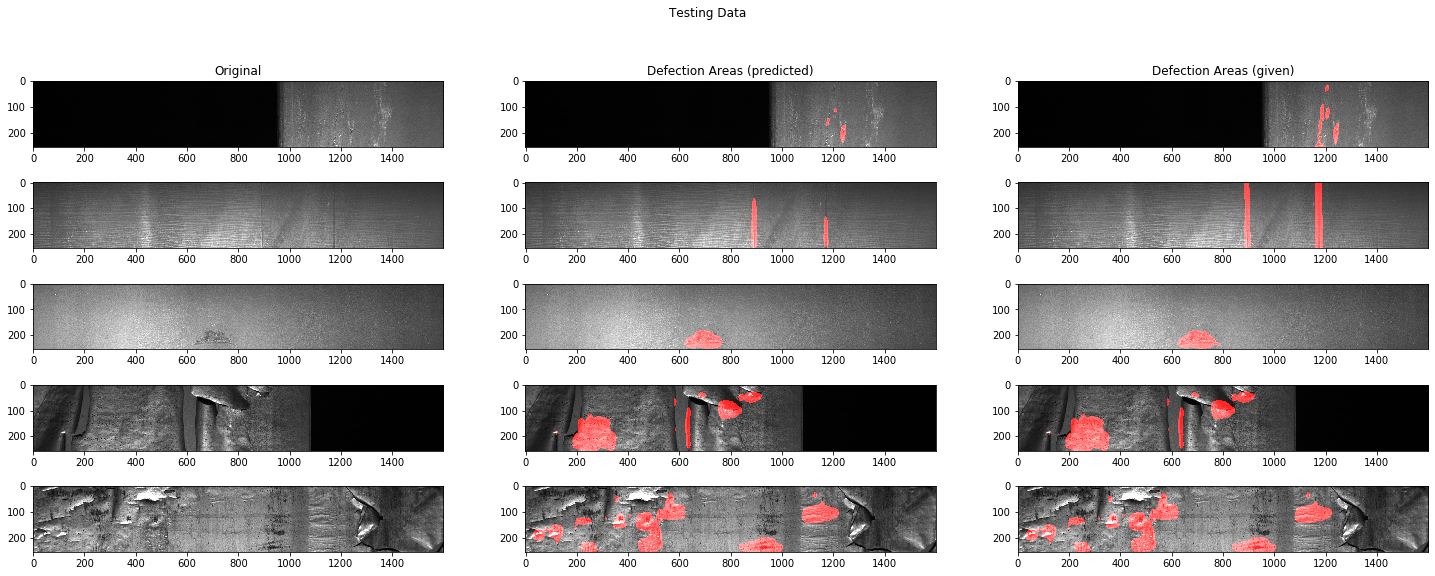

In [0]:
# 4 - Calculate area
# 4.1 - plot area
test_masked = data_analysis.copy()
test_masked = test_masked[ ~(test_masked['PredictedEncodedPixels'] == '')]

test_images_masked = sorted(set(list(test_masked['Image'] )), key = list(test_masked['Image'] ).index)
test_masked = test_masked.reset_index()
del test_masked['index']

display(test_masked.head())

fig = plt.figure(figsize = (25,9))
fig.suptitle('Testing Data')
columns = 3
rows = 5
i = 1
counter = 0
offset = 170
while counter <= 4:
    if(test_masked.loc[i+ offset]['PredictedEncodedPixels'] == ''): 
      i += 3
      continue

    # first image
    ax = fig.add_subplot(rows, columns, 3*counter + 1 )
    img = cv2.imread( 'train_images/' + test_masked.loc[i + offset]['Image'] )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if i == 1 :ax.set_title('Original')
    plt.imshow(img)
    
    # second image
    img1 = img
    ax = fig.add_subplot(rows, columns, 3*counter + 2)
    mask = rle2mask_visualization( test_masked.loc[i+ offset]['PredictedEncodedPixels'], img1.shape )
    img1[mask == 1,0] = 255
    if i == 1 : ax.set_title('Defection Areas (predicted)')
    plt.imshow(img1)

    # third image
    img2 = img
    ax = fig.add_subplot(rows, columns, 3*counter + 3)

    if not(isinstance(test_masked.loc[i+ offset]['EncodedPixels'] , str) ): 
       plt.imshow(img2)
    else:
      mask = rle2mask_visualization( test_masked.loc[i+ offset]['EncodedPixels'], img2.shape )
      img2[mask == 1,0] = 255
      plt.imshow(img2)
    if i == 1: ax.set_title('Defection Areas (given)')

    
    area_defected = len(img1[mask == 1,0])
    area_total = 256 * 1600
    coverage = area_defected/ area_total * 100

    print("Coverage is : " + str(np.round(coverage,2)) + "%")

    i += 3
    counter += 1



In [0]:
# 4.2 - calculate coverage

data_analysis = data_analysis.reset_index()
del data_analysis['index']
data_analysis['TotalArea'] = [256*1600] * len(data_analysis)
data_analysis['RealDefectedArea'] = ''
data_analysis['PredictiveDefectedArea'] = ''


for i in range( len(data_analysis) ):
  img = cv2.imread( 'train_images/' + data_analysis.loc[i]['Image'] )
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  defected_predicted_area = 0
  defected_area = 0
  total_area = 256 * 1600

  if data_analysis.loc[i]['PredictedEncodedPixels'] != '':
    mask = rle2mask_visualization( data_analysis.loc[i]['PredictedEncodedPixels'], img.shape )
    img[mask == 1,0] = 255
    defected_predicted_area = len(img[mask == 1,0])

  if isinstance(data_analysis.loc[i]['EncodedPixels'] , str):
    mask = rle2mask_visualization( data_analysis.loc[i]['EncodedPixels'], img.shape )
    img[mask == 1,0] = 255
    defected_area = len(img[mask == 1,0])

  coverage = defected_area/ total_area * 100
  coverage_predicted = defected_predicted_area/ total_area * 100
  data_analysis['RealDefectedArea'].iloc[i] = defected_area
  data_analysis['PredictiveDefectedArea'].iloc[i] = defected_predicted_area

del data_analysis['TotalArea']
display(data_analysis.head())



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Image,Label,EncodedPixels,PredictedEncodedPixels,RealClass,PredictiveClass,RealDefectedArea,PredictiveDefectedArea
0,cc0ef2b5b.jpg,1,NaN,,0,0,0,0
1,cc0ef2b5b.jpg,2,NaN,,0,0,0,0
2,cc0ef2b5b.jpg,3,NaN,41946 1 41948 1 41950 1 41952 1 41954 1 41956 ...,0,3,0,22464
3,cc0ef2b5b.jpg,4,NaN,,0,0,0,0
4,cc12d964f.jpg,1,NaN,,0,0,0,0


# 10 - Model Evaluation

In [0]:
CLASSFICATION_ACCURACY = 100 * len(data_analysis[ data_analysis['RealClass'] == data_analysis['PredictiveClass'] ])/len(data_analysis)
print("Classification Test accuracy : " + str(np.round(CLASSFICATION_ACCURACY,2)) + "%")



Classification Test accuracy : 82.18%


# 11 - Submit Analytics

In [0]:
# 1 - Analytics so far
#PREDICTIONS_perImage = PREDICTIONS_perImage.reset_index()
#del PREDICTIONS_perImage['index']

# 2 - Final Analytics
#data_analytics = PREDICTIONS_perImage.merge(AREA_perImage, on=['Image', 'Label'])
#data_analytics['ID'] = data_analytics['Image'].apply(lambda x : x.split('.')[0])
#data_analytics = data_analytics[['ID','Label','ImageClassPrediction', 'ImagePrediction', 'TotalArea', 'RealDefectedArea', 'PredictiveDefectedArea']]
display(data_analysis.head(5))

#data_analysis.to_csv('data_analytics.csv', index = False)

data_analysis2 = data_analysis.copy()
del data_analysis2['Label']
del data_analysis2['PredictedEncodedPixels']
del data_analysis2['EncodedPixels']
data_analysis2['RealClass'] = data_analysis2['RealClass'].apply(lambda x : int(x))
data_analysis2['PredictiveClass']  = data_analysis2['PredictiveClass'].apply(lambda x : int(x))
data_analysis2 = data_analysis2.groupby('Image').agg(np.sum)

data_analysis2.reset_index(inplace=True)


display(data_analysis2.head(5))
data_analysis2.to_csv('data_analytics2.csv', index = False)


x = list(data_analysis2['PredictiveClass'] )
y = list(set(list(data_analysis2['RealClass'] )))
print(y)

,Image,Label,EncodedPixels,PredictedEncodedPixels,RealClass,PredictiveClass,RealDefectedArea,PredictiveDefectedArea
0,cc0ef2b5b.jpg,1,NaN,,0,0,0,0
1,cc0ef2b5b.jpg,2,NaN,,0,0,0,0
2,cc0ef2b5b.jpg,3,NaN,41946 1 41948 1 41950 1 41952 1 41954 1 41956 ...,0,3,0,22464
3,cc0ef2b5b.jpg,4,NaN,,0,0,0,0
4,cc12d964f.jpg,1,NaN,,0,0,0,0


,Image,RealClass,PredictiveClass,RealDefectedArea,PredictiveDefectedArea
0,cc0ef2b5b.jpg,0,3,0,22464
1,cc12d964f.jpg,0,3,0,6785
2,cc21f2f40.jpg,4,3,12018,18126
3,cc2a3d558.jpg,0,3,0,20921
4,cc3a294d4.jpg,0,3,0,14787


[0, 1, 2, 3, 4, 5, 6, 7]


# 12 - Test Our Own Image

8/8 [==============================] - 0s 11ms/step


8it [00:00, 40.92it/s]


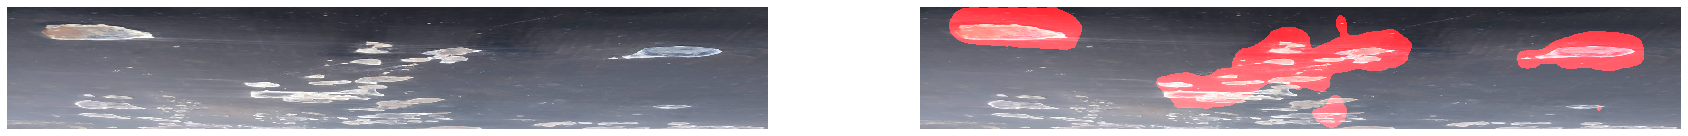

In [167]:
num = 8
sample_test_img_names = [str(i)+'.jpg' for i in range(1,num + 1)]
sample_test_imgs = pd.DataFrame(sample_test_img_names, columns = ['Image'] )
sample_test_img_info = pd.DataFrame( columns = ['ImageId_ClassId','EncodedPixels','Image','Label','hasMask'] )
for i in range(num):
  sample_test_img_info.loc[i] = [sample_test_img_names[i] + '_1', np.nan, sample_test_img_names[i],'1','False']

sample_test_df = []

batch_idx = list( range(0, min(sample_test_img_info.shape[0], 500)))

test_generator = DataGenerator(
    batch_idx,
    df = sample_test_imgs,
    shuffle = False,
    mode = 'predict',
    base_path = 'data_extra',
    target_df = sample_test_img_info,
    batch_size = 1,
    n_classes = 1
)

batch_pred_masks = model.predict_generator(
    test_generator, 
    workers = 1,
    verbose = 1
)


for j, b in tqdm(enumerate(batch_idx)):
  filename = sample_test_imgs['Image'].iloc[b]
  image_df = sample_test_img_info[sample_test_img_info['Image'] == filename].copy()
  
  pred_masks = batch_pred_masks[j, ].round().astype(int)
  pred_rles = build_rles(pred_masks)[2]
  
  image_df['PredictedEncodedPixels'] = pred_rles
  sample_test_df.append(image_df)

sample_test_df = pd.concat(sample_test_df)


# plot test images
fig = plt.figure(figsize = (30,5))
columns = 2
rows = 8
counter = 8

for i in range(1,17,2):
    #  image
    ax = fig.add_subplot(rows, columns, i )
    img = cv2.imread( 'data_extra/' + sample_test_imgs.loc[counter]['Image'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(img)
    
    # predicted image
    ax = fig.add_subplot(rows, columns, i + 1)
    mask = rle2mask_visualization( sample_test_df.loc[counter]['PredictedEncodedPixels'] , img.shape )
    img[mask == 1,0] = 255
    plt.axis('off')
    plt.imshow(img)

    counter += 1
  
fig.savefig('images.png', transparent=True)
